Here we will try to build a hierarchical regression model, where each component (i.e. dimension) is normally distributed.  In microbial ecology, we are creating this generative model, because we expect microbes to be normally distributed around an optimal environment.  For instance, microbes have been noted to only exist in specific pH ranges.

The model that we are trying to build is parametered as follows

$$ x_j \sim N(u_j, \sigma_j)$$

where $x_i$ is the $i_{th}$ species, that is distributed around $u_i$, which is a value

$$ u \; |\; G \sim N(G\beta,\; \Sigma_G)$$

Let's first try to simulate some data, and see if we can fit it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson, multinomial, multivariate_normal
%matplotlib inline

In [2]:
num_samples = 5
num_features = 10
gradient = np.linspace(0, 10, num_samples)
mu = np.linspace(0, 10, num_features)
sigma = 2
xs = [norm.pdf(gradient, loc=mu[i], scale=sigma)
      for i in range(len(mu))]
table = np.vstack(xs).T

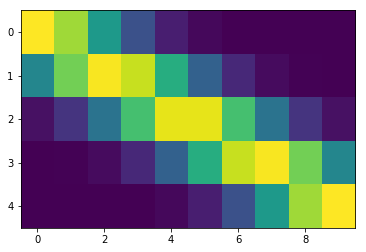

In [3]:
plt.imshow(table, aspect='auto', interpolation='nearest')

Here, we expect $\beta \approx \frac{10}{5}$.  Let's attempt to parameterize our model below.

In [4]:
import pystan

#----------------------------------------------
# Create the Stan model
#  this is done by defining a string of Stan code.

fit_code = """
data {
    int<lower=0> N;  // number of samples
    int<lower=0> D;  // number of dimensions
    real g[N];       // gradient values
    matrix[D, N] x;  // microbe abundances
}

parameters {
    real u[D];              // means for each species distribution
    real<lower=0> sigma[D]; // variance for each species distribution
    // parameters required for linear regression on the species means
    real alpha;
    real beta;
    real<lower=0> sigmaG;
}


model {

    alpha ~ normal(0,10);    
    beta ~ normal(0,10);        
    sigmaG ~ cauchy(0,5);
    for (i in 1:N)
        u[i] ~ normal(alpha + beta * g[i], sigmaG);

    for (j in 1:D){
        sigma[j] ~ cauchy(0,5);
        for (i in 1:N)
            x[j, i] ~ normal(u[j], sigma[j]);
    }
}
"""

In [5]:
# perform the fit
fit_data = {'N': len(gradient), 'D': table.shape[1], 'x': table.T, 'g': gradient}
fit = pystan.stan(model_code=fit_code, data=fit_data, iter=25000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5e7ea3c33ae3a5451feaf5b5156cb95a NOW.


In [6]:
fit

Inference for Stan model: anon_model_5e7ea3c33ae3a5451feaf5b5156cb95a.
4 chains, each with iter=25000; warmup=12500; thin=1; 
post-warmup draws per chain=12500, total post-warmup draws=50000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
u[0]       0.06  9.9e-4   0.04  -0.03   0.04   0.06   0.09   0.15   1995    1.0
u[1]       0.07  7.8e-4   0.04-6.0e-3   0.05   0.07   0.09   0.15   2286    1.0
u[2]       0.08  5.7e-4   0.03 9.6e-3   0.06   0.08    0.1   0.14   3415    1.0
u[3]       0.08  1.1e-3   0.04 8.7e-3   0.06   0.08    0.1   0.15    994    1.0
u[4]       0.08  1.3e-3   0.04 1.8e-4   0.06   0.08   0.11   0.17   1036    1.0
u[5]       0.08  4.8e-3   0.06  -0.04   0.04   0.07   0.11    0.2    169   1.02
u[6]       0.08  2.8e-3   0.06  -0.04   0.05   0.08   0.12   0.21    527   1.01
u[7]       0.08  2.5e-3   0.07  -0.04   0.04   0.07   0.11   0.21    725   1.01
u[8]       0.08  4.3e-3   0.07  -0.06   0.04   0.08   0.11    0.2    262   1.02
u[9]   

In [7]:
traces = fit.extract()

In [23]:
gradient

array([  0. ,   2.5,   5. ,   7.5,  10. ])

In [25]:
traces['u'].mean(axis=0)

array([ 0.06367341,  0.07074737,  0.07676219,  0.08039202,  0.08370377,
        0.07501824,  0.08325776,  0.07569326,  0.07581956,  0.0719533 ])